# Sort candidate pulse sequences

From the job output, keep only the lines that contain the text "candidate pulse sequence" (can do `cat rl_pulse... | grep "candidate pulse sequence"`) or use regex to delete all lines that don't contain candidate sequences via `^((?!candidate pulse sequence).)*$`.

In [11]:
import sys
import os
import re
import pandas as pd
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import multiprocessing as mp
import importlib

In [2]:
sys.path.append('..')

In [3]:
import pulse_sequences as ps

In [112]:
# importlib.reload(ps)

<module 'pulse_sequences' from '../pulse_sequences.py'>

In [65]:
path = '../../data/2021-02/20210228-203135/'

In [66]:
candidates = []
with open(os.path.join(path, 'candidates.txt')) as file:
    for line in file:
        candidates.append(line)

In [67]:
c2 = []
for c in candidates:
    try:
        m = re.search(r'(.*?) candidate pulse sequence from \d+ \((.*?), array\((.*?)\), (.*?)\)\n', c)
        c2.append({
            'timestamp': m.group(1),
            'sequence': m.group(2),
            'last_pulse': m.group(3),
            'value': float(m.group(4))
        })
    except Exception as e:
        print('exception caught')
        # print(c)

In [68]:
len(c2)

3875

In [69]:
df = pd.DataFrame(c2)

array([[<AxesSubplot:title={'center':'value'}>]], dtype=object)

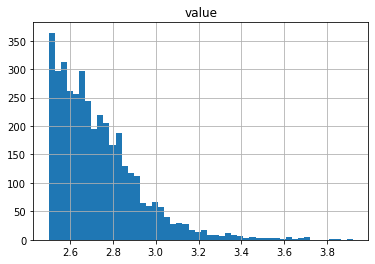

In [70]:
df.hist('value', bins=50)

In [71]:
df.sort_values('value', ascending=False, inplace=True)
# df

In [72]:
df['sequence'] = df['sequence'].apply(lambda x: [int(i) for i in x[1:-1].split(',')])

In [73]:
df['last_pulse'] = df['last_pulse'].apply(lambda x: [float(i) for i in x[1:-1].split(',')])

In [74]:
df['last_pulse'] = df['last_pulse'].apply(lambda x: np.argwhere(x)[0][0])

In [75]:
df['full_sequence'] = df['sequence'] + df['last_pulse'].apply(lambda x: [x])

In [76]:
df.head()

,timestamp,sequence,last_pulse,value,full_sequence
2429,2021-03-01 12:38:41.265390,"[3, 0, 1, 0, 1, 1, 3, 0, 2, 1, 3, 1, 0, 3, 0, ...",1,3.920358,"[3, 0, 1, 0, 1, 1, 3, 0, 2, 1, 3, 1, 0, 3, 0, ..."
662,2021-03-01 01:15:00.418460,"[3, 0, 0, 1, 3, 3, 0, 2, 0, 1, 1, 1, 3, 3, 3, ...",0,3.851370,"[3, 0, 0, 1, 3, 3, 0, 2, 0, 1, 1, 1, 3, 3, 3, ..."
2311,2021-03-01 11:54:12.847116,"[1, 0, 4, 0, 4, 4, 0, 0, 0, 3, 1, 0, 1, 0, 0, ...",0,3.831153,"[1, 0, 4, 0, 4, 4, 0, 0, 0, 3, 1, 0, 1, 0, 0, ..."
2266,2021-03-01 11:38:49.933396,"[1, 4, 0, 4, 4, 4, 0, 0, 0, 3, 1, 3, 1, 1, 4, ...",0,3.715936,"[1, 4, 0, 4, 4, 4, 0, 0, 0, 3, 1, 3, 1, 1, 4, ..."
531,2021-03-01 00:26:28.723093,"[4, 0, 1, 4, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 3, ...",0,3.711630,"[4, 0, 1, 4, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 3, ..."


In [77]:
df.to_csv(os.path.join(path, 'candidates_sorted.csv'))

## Set up spin system

In [78]:
dipolar_strength = 1e2
pulse_width = 1e-5  # time is relative to chemical shift strength
delay = 1e-4
rot_error = 1e-2
N = 3  # number of spins
ensemble_size = 100

In [79]:
X, Y, Z = ps.get_collective_spin(N)

In [80]:
Hsys_ensemble = []
for _ in range(ensemble_size):
    Hsys_ensemble.append(ps.get_Hsys(N=N, dipolar_strength=dipolar_strength))
pulses_ensemble = []
for H in Hsys_ensemble:
    rot = np.random.normal(scale=rot_error)
    pulses_ensemble.append(ps.get_pulses(
        H, X, Y, Z, pulse_width=pulse_width, delay=delay, rot_error=rot
    ))

In [81]:
Utarget = qt.identity(Hsys_ensemble[0].dims[0])

## Check candidates

In [254]:
# read from file if not loaded above
# df = pd.read_csv('../../data/2021-02/20210219-082529/candidates_sorted.csv')

In [207]:
# unique_sequences = df['full_sequence'].map(lambda x: tuple(x)).unique()
# unique_sequences = [list(i) for i in unique_sequences]
# len(unique_sequences)

In [82]:
N_seq = 25
fidelities = np.zeros(N_seq)
with mp.Pool(4) as p:
    fidelities = p.starmap(ps.get_mean_fidelity,
                           [(c, Utarget, pulses_ensemble)
                            for c in df['full_sequence'].iloc[:N_seq]])
fidelities = np.array(fidelities)

Text(0, 0.5, 'reward estimate (from job)')

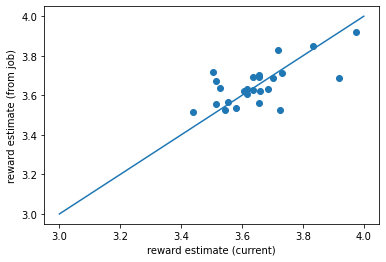

In [83]:
# confirm that calculated rewards match what was calculated from the job
plt.scatter(-np.log10(1 - fidelities), df['value'].iloc[:N_seq])
plt.plot([3, 4], [3, 4])
plt.xlabel('reward estimate (current)')
plt.ylabel('reward estimate (from job)')

In [84]:
np.argmin(1 - fidelities), (1 - fidelities).min(), -np.log10((1 - fidelities).min())

(0, 0.00010605749880054915, 3.9744586192495923)

In [85]:
df.iloc[0]

timestamp                               2021-03-01 12:38:41.265390
sequence         [3, 0, 1, 0, 1, 1, 3, 0, 2, 1, 3, 1, 0, 3, 0, ...
last_pulse                                                       1
value                                                      3.92036
full_sequence    [3, 0, 1, 0, 1, 1, 3, 0, 2, 1, 3, 1, 0, 3, 0, ...
Name: 2429, dtype: object

In [86]:
print(df['full_sequence'].iloc[0])

[3, 0, 1, 0, 1, 1, 3, 0, 2, 1, 3, 1, 0, 3, 0, 0, 4, 4, 2, 2, 4, 3, 4, 3, 1, 4, 4, 3, 0, 4, 4, 2, 4, 4, 3, 4, 0, 4, 3, 1, 4, 4, 4, 4, 4, 0, 0, 1]


In [49]:
df.iloc[0:2]

,timestamp,sequence,last_pulse,value,full_sequence
2429,2021-03-01 12:38:41.265390,"[3, 0, 1, 0, 1, 1, 3, 0, 2, 1, 3, 1, 0, 3, 0, ...",1,3.920358,"[3, 0, 1, 0, 1, 1, 3, 0, 2, 1, 3, 1, 0, 3, 0, ..."
662,2021-03-01 01:15:00.418460,"[3, 0, 0, 1, 3, 3, 0, 2, 0, 1, 1, 1, 3, 3, 3, ...",0,3.851370,"[3, 0, 0, 1, 3, 3, 0, 2, 0, 1, 1, 1, 3, 3, 3, ..."


In [271]:
# plt.hist(1 - fidelities, bins=30)
# # fit exponential distribution
# X = np.linspace(0, .1, 100)
# Y = np.exp(-1 / np.mean(1 - fidelities) * X)
# plt.plot(X, Y * 4)

## Format and print pulse sequence

In [5]:
names = [
    r'\tau_{\pi/2}, \tau',
    r'X, \tau',
    r'-X, \tau',
    r'Y, \tau',
    r'-Y, \tau',
]

In [9]:
sequence_string = [names[i] for i in ps.az48]

print('$', ', '.join(sequence_string[:8]), '$')
print('$', ', '.join(sequence_string[8:16]), '$')
print('$', ', '.join(sequence_string[16:24]), '$')
print('$', ', '.join(sequence_string[24:32]), '$')
print('$', ', '.join(sequence_string[32:40]), '$')
print('$', ', '.join(sequence_string[40:48]), '$')

$ -Y, \tau, -X, \tau, X, \tau, X, \tau, -X, \tau, X, \tau, -X, \tau, \tau_{\pi/2}, \tau $
$ -Y, \tau, \tau_{\pi/2}, \tau, Y, \tau, X, \tau, Y, \tau, -X, \tau, Y, \tau, \tau_{\pi/2}, \tau $
$ \tau_{\pi/2}, \tau, -X, \tau, -Y, \tau, -Y, \tau, -X, \tau, X, \tau, -X, \tau, -X, \tau $
$ -X, \tau, -Y, \tau, \tau_{\pi/2}, \tau, \tau_{\pi/2}, \tau, -X, \tau, Y, \tau, -Y, \tau, Y, \tau $
$ -Y, \tau, \tau_{\pi/2}, \tau, X, \tau, -Y, \tau, Y, \tau, X, \tau, Y, \tau, -Y, \tau $
$ \tau_{\pi/2}, \tau, \tau_{\pi/2}, \tau, -Y, \tau, \tau_{\pi/2}, \tau, -X, \tau, \tau_{\pi/2}, \tau, \tau_{\pi/2}, \tau, -Y, \tau $


$ -Y, \tau, -X, \tau, X, \tau, X, \tau, -X, \tau, X, \tau, -X, \tau, \tau_{\pi/2}, \tau, -Y, \tau, \tau_{\pi/2}, \tau, Y, \tau, X, \tau $
$ Y, \tau, -X, \tau, Y, \tau, \tau_{\pi/2}, \tau, \tau_{\pi/2}, \tau, -X, \tau, -Y, \tau, -Y, \tau, -X, \tau, X, \tau, -X, \tau, -X, \tau $
$ -X, \tau, -Y, \tau, \tau_{\pi/2}, \tau, \tau_{\pi/2}, \tau, -X, \tau, Y, \tau, -Y, \tau, Y, \tau, -Y, \tau, \tau_{\pi/2}, \tau, X, \tau, -Y, \tau $
$ Y, \tau, X, \tau, Y, \tau, -Y, \tau, \tau_{\pi/2}, \tau, \tau_{\pi/2}, \tau, -Y, \tau, \tau_{\pi/2}, \tau, -X, \tau, \tau_{\pi/2}, \tau, \tau_{\pi/2}, \tau, -Y, \tau $

Pulse sequence 23:

$ -X, \tau, Y, \tau, Y, \tau, Y, \tau, Y, \tau, -X, \tau, Y, \tau, -X, \tau, -Y, \tau, -X, \tau, -Y, \tau, X, \tau $
$ -X, \tau, Y, \tau, Y, \tau, Y, \tau, \tau_{\pi/2}, \tau, Y, \tau, \tau_{\pi/2}, \tau, -X, \tau, Y, \tau, -X, \tau, -X, \tau, -X, \tau $
$ Y, \tau, -X, \tau, \tau_{\pi/2}, \tau, -Y, \tau, -X, \tau, -X, \tau, -X, \tau, \tau_{\pi/2}, \tau, -Y, \tau, -Y, \tau, Y, \tau, X, \tau $
$ Y, \tau, -Y, \tau, -Y, \tau, \tau_{\pi/2}, \tau, \tau_{\pi/2}, \tau, \tau_{\pi/2}, \tau, -X, \tau, -X, \tau, -X, \tau, \tau_{\pi/2}, \tau, Y, \tau, -X, \tau $